# Convolutional Neural Networks

Convolutional Neural Networks (CNNs) are a specialized type of artificial neural network designed to process data structured in a grid, such as images. CNNs are commonly used in tasks like image recognition, object detection, and video analysis due to their ability to learn spatial hierarchies of features.

## Key Components of CNNs:
- Convolutional Layers:
  Convolutional layers are CNNs' prominent distinguishing feature from other neural network architectures. The convolutional layers correspond to filters (kernels) slid across the input data to extract local features. Each filter detects different patterns, such as edges or textures.
- Pooling Layers:
  - Pooling layers reduce the data's spatial dimensions (height and width) using techniques like max pooling or average pooling. Pooling reduces the number of parameters, reduces computational costs, and helps limit overfitting.
- Activation Functions:
  Activation functions, such as ReLU, are applied to introduce non-linearity into the model, allowing the network to learn more complex patterns.
- Fully Connected Layers:
  - In a CNN, fully connected layers are applied near the network's end to combine features learned by the convolutional and pooling layers to make final predictions.

## Benefits of CNNs
CNNs extract low-level features, such as edges and corners, in early layers. In deeper layers, the low-level features are progressively combined into higher-level patterns, such as shapes and objects.
- Weight sharing in the convolutional layers significantly reduces the number of parameters compared to fully connected networks.
- CNNs can recognize objects in images regardless of their position, making them robust to spatial transformations.
- CNNs automatically learn relevant features from the raw data, reducing the need for manual feature engineering.
- CNNs have achieved state-of-the-art results in many computer vision tasks.

In this notebook, we will use the simple MNSIT data to understand various aspects of CNNs. The following code block imports libraries we will use.

In [1]:
import pathlib
import time

import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

The following code block sets the random seed for PyTorch. This should ensure stable results if the notebook is run top-to-bottom, i.e., "Restart and Run All Cells." It will not guarantee reproducibility otherwise.

In [2]:
torch.manual_seed(0)

The following code block loads the MNIST feature and target data. One-hot-encoding is applied to the target data.

In [3]:
feature_data_filepath = pathlib.Path('data/mnist_features.parquet')
target_data_filepath = pathlib.Path('data/mnist_target.parquet')

feature_data = pl.read_parquet(
    feature_data_filepath
).with_columns(
    pl.all()/255.0
)

target_data = pl.read_parquet(
    target_data_filepath
).cast(
    pl.Int32
).to_dummies()

The following code block extracts and plots one of the images from the MNIST feature data

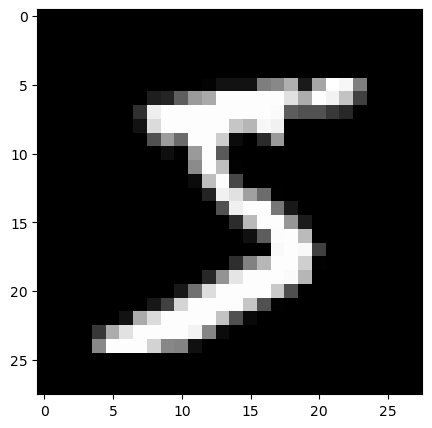

In [4]:
test_image = feature_data[0].to_numpy().reshape(28, 28)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.imshow(
    test_image,
    cmap='gray', 
    vmin=0, 
    vmax=1
)

plt.show()

# Understanding Convolutional Layers

As mentioned earlier, convolutional layers are the prominent distinguishing feature of CNNs from other neural network architectures. The convolutional layers correspond to filters (kernels) slid across the input data to extract local features. Each filter detects different patterns, such as edges or textures. The step size used to slide the filter over the image is called the *stride*. Depending on how the stride is set, some regions of an image may not be included in the features map that results from applying a convolutional filter. Sometimes, padding is added around the input to ensure that edge features are captured.

The following formula can be used to define the output size that will result from applying a convolutional filter.

$\displaystyle \mbox{Output Size}=\left\lfloor \frac{W−K+2P}{S} + 1\right\rfloor,$ where:

$W$ = input size (width/height),</br>
$K$ = kernel size,</br>
$P$ = padding,</br>
$S$ = stride.</br>

When applying a filter to a given set of pixels, the filter values are multiplied by the pixel values, and the sum is computed and returned.

The following code block shows the result of applying a filter known as a Sobel filter to our test image. The filter size is $ 3 \times 3$, and the code uses a stride of 2 with no padding. This is sometimes referred to as *valid padding* because the window only slides over the valid parts of the input image.

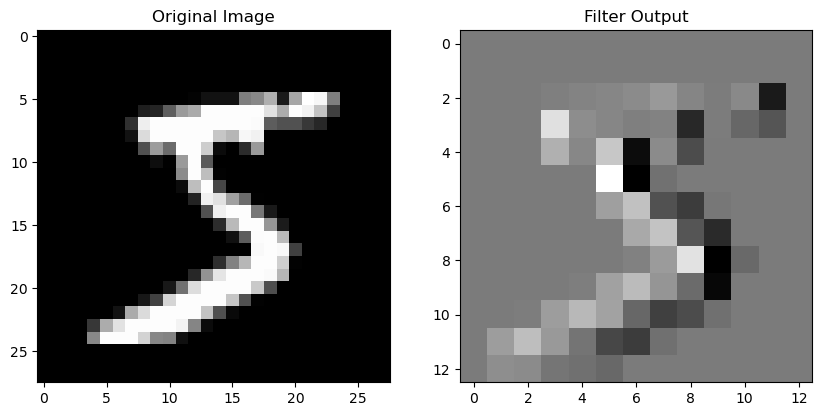

In [5]:
sobel_filter = np.array([
    [-1, 0, 1], 
    [-2, 0, 2],
    [-1, 0, 1]
])

filter_size = len(sobel_filter)
stride = 2
padding = 0

conv_output_height = np.floor((test_image.shape[0] - filter_size - 2*padding)/stride + 1).astype(np.int32)
conv_output_width =  np.floor((test_image.shape[1] - filter_size - 2*padding)/stride + 1).astype(np.int32)

# Initialize the output matrix
conv_output = np.zeros((conv_output_height, conv_output_width))

for i in range(0, conv_output_height):
    for j in range(0, conv_output_width):
        row_start = i * stride
        col_start = j * stride
        
        window = test_image[row_start:row_start + filter_size, col_start:col_start + filter_size]
        conv_output[i, j] = np.sum(window * sobel_filter)

mosaic = [
    ['Original Image', 'Filter Output'],
]
plot_mapper = {
    'Original Image': test_image,
    'Filter Output': conv_output,
}


fig, ax = plt.subplot_mosaic(mosaic, figsize=(10, 10))

for subplot_title, subplot_array in plot_mapper.items(): 

    ax[subplot_title].imshow(
        subplot_array,
        cmap='gray', 
    )
    ax[subplot_title].set_title(subplot_title)

plt.show()

In a CNN, many convolutional filters are learned at each convolutional layer. Each filter learns weights that allow it to detect useful patterns for the downstream prediction task.

# Understanding Pooling

As mentioned earlier, pooling layers reduce the data's spatial dimensions (height and width) using techniques like max pooling or average pooling. Pooling reduces the number of parameters, reduces computational costs, and helps limit overfitting. Like what we saw with convolutional filters, pooling filters will have a size and a stride. Given values for these parameters, the following formula can be used to compute the output size.

$\displaystyle \mbox{Output Size}=\left\lfloor \frac{W−F}{S} + 1 \right\rfloor,$ where:

$W$ = input size (width/height),</br>
$F$ = filter (pooling) size,</br>
$S$ = stride.</br>

The following code block applies a ReLU activation to our Sobel filter output and then uses max pooling to reduce dimensionality further.

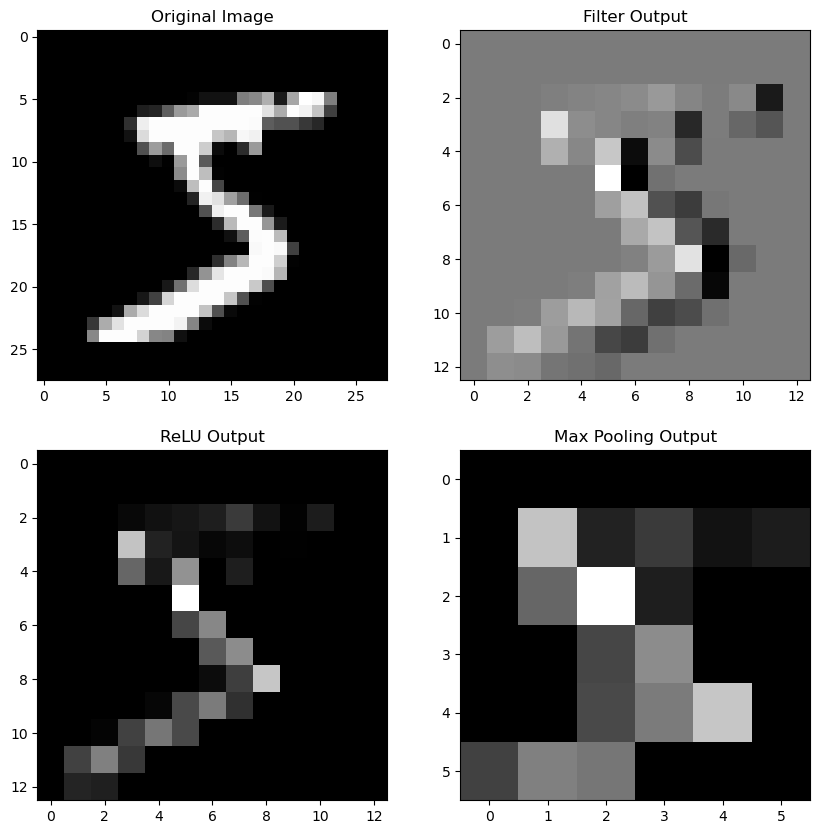

In [6]:
sobel_filter = np.array([
    [-1, 0, 1], 
    [-2, 0, 2],
    [-1, 0, 1]
])

filter_size = len(sobel_filter)
stride = 2
padding = 0

conv_output_height = np.floor((test_image.shape[0] - filter_size - 2*padding)/stride + 1).astype(np.int32)
conv_output_width =  np.floor((test_image.shape[1] - filter_size - 2*padding)/stride + 1).astype(np.int32)

# Initialize the output matrix
conv_output = np.zeros((conv_output_height, conv_output_width))

for i in range(0, conv_output_height):
    for j in range(0, conv_output_width):
        row_start = i * stride
        col_start = j * stride
        
        window = test_image[row_start:row_start + filter_size, col_start:col_start + filter_size]
        conv_output[i, j] = np.sum(window * sobel_filter)

relu_output = np.maximum(0, conv_output)

pool_size = 2
stride_pool = 2

# Calculate output dimensions for max pooling
pool_output_height = np.floor((relu_output.shape[0] - pool_size) / stride_pool + 1).astype(np.int32)
pool_output_width = np.floor((relu_output.shape[1] - pool_size) / stride_pool + 1).astype(np.int32)

# Initialize the output matrix for max pooling
pool_output = np.zeros((pool_output_height, pool_output_width))

# Apply Max Pooling
for i in range(0, pool_output_height):
    for j in range(0, pool_output_width):
        row_start = i * stride_pool
        col_start = j * stride_pool
        
        window = relu_output[row_start:row_start + pool_size, col_start:col_start + pool_size]
        pool_output[i, j] = np.max(window)

mosaic = [
    ['Original Image', 'Filter Output'],
    ['ReLU Output', 'Max Pooling Output']
]
plot_mapper = {
    'Original Image': test_image,
    'Filter Output': conv_output,
    'ReLU Output': relu_output,
    'Max Pooling Output': pool_output,
}


fig, ax = plt.subplot_mosaic(mosaic, figsize=(10, 10))

for subplot_title, subplot_array in plot_mapper.items(): 

    ax[subplot_title].imshow(
        subplot_array,
        cmap='gray', 
    )
    ax[subplot_title].set_title(subplot_title)

plt.show()

The following code block repeats the steps with a different filter that sharpens images.

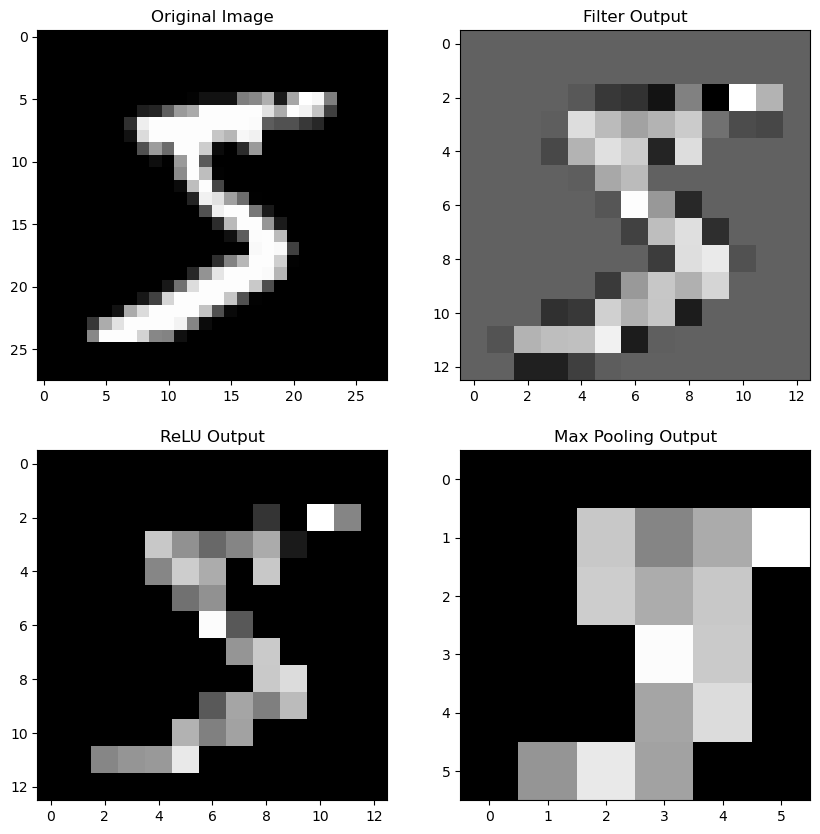

In [7]:
sharpening_filter = np.array([
    [0, -1, 0], 
    [-1, 5, -1],
    [0, -1, 0]
])

filter_size = len(sharpening_filter)
stride = 2
padding = 0

conv_output_height = np.floor((test_image.shape[0] - filter_size - 2*padding)/stride + 1).astype(np.int32)
conv_output_width =  np.floor((test_image.shape[1] - filter_size - 2*padding)/stride + 1).astype(np.int32)

# Initialize the output matrix
conv_output = np.zeros((conv_output_height, conv_output_width))

for i in range(0, conv_output_height):
    for j in range(0, conv_output_width):
        row_start = i * stride
        col_start = j * stride
        
        window = test_image[row_start:row_start + filter_size, col_start:col_start + filter_size]
        conv_output[i, j] = np.sum(window * sharpening_filter)

relu_output = np.maximum(0, conv_output)

pool_size = 2
stride_pool = 2

# Calculate output dimensions for max pooling
pool_output_height = np.floor((relu_output.shape[0] - pool_size) / stride_pool + 1).astype(np.int32)
pool_output_width = np.floor((relu_output.shape[1] - pool_size) / stride_pool + 1).astype(np.int32)

# Initialize the output matrix for max pooling
pool_output = np.zeros((pool_output_height, pool_output_width))

# Apply Max Pooling
for i in range(0, pool_output_height):
    for j in range(0, pool_output_width):
        # Calculate the starting row and column indices
        row_start = i * stride_pool
        col_start = j * stride_pool
        
        # Extract the 2x2 region for max pooling
        window = relu_output[row_start:row_start + pool_size, col_start:col_start + pool_size]
        
        # Apply max pooling (get the maximum value in the window)
        pool_output[i, j] = np.max(window)

mosaic = [
    ['Original Image', 'Filter Output'],
    ['ReLU Output', 'Max Pooling Output']
]
plot_mapper = {
    'Original Image': test_image,
    'Filter Output': conv_output,
    'ReLU Output': relu_output,
    'Max Pooling Output': pool_output,
}


fig, ax = plt.subplot_mosaic(mosaic, figsize=(10, 10))

for subplot_title, subplot_array in plot_mapper.items(): 

    ax[subplot_title].imshow(
        subplot_array,
        cmap='gray', 
    )
    ax[subplot_title].set_title(subplot_title)

plt.show()

# Creating a Simple CNN with PyTorch

We will now look at how to construct a simple CNN using Pytorch. The structure of the CNN we will use is depicted in the following flowchart. We will use two convolutional layers, ReLU activation functions, and Max pooling.

```mermaid
flowchart LR

A[Input Layer<br>28x28x1] --> B[Conv1 Layer<br>3x3<br>stride 1<br>32 filters<br>Output: 26x26x32]
B --> BRelu[Relu<br>Output: 26x26x32]
BRelu --> C[Max Pooling 1<br>2x2<br>stride 2<br>Output: 13x13x32]
C --> D[Conv2 Layer<br>3x3<br>stride 1<br>64 filters<br>Output: 11x11x64]
D --> END:::hidden


START:::hidden --> DRelu[Relu<br>Output: 1x11x64]
DRelu --> E[Max Pooling 2<br>2x2<br>stride 2<br>Output: 5x5x64]
E --> F[Flatten Layer<br>5x5x64 = 1600]
F --> G[FC1 Layer<br>128 units]
G --> H[FC2 Layer<br>10 units]

classDef hidden display: none;
```

We will send the data to our PyTorch model in batches. Thus, we will define a Dataset class and use a Dataloader to handle this batching. The following code block defines the Dataset class: `MNISTDataset`.

In [8]:
# Custom Dataset class
class MNISTDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        image = self.features[idx].reshape(28, 28).astype('float32')
        label = self.targets[idx].astype('float32')
        return torch.tensor(image), torch.tensor(label)

The following code block:
- reloads the data,
- divides the feature data by 255 to convert all values to be in [0, 1],
- applies one-hot-encoding to the target data,
- splits the data into train, validation, and test datasets,
- and uses the custom `MNISTDataset` class to create PyTorch Dataset objects for each set. 

In [9]:
# Load data from parquet files
feature_data_filepath = pathlib.Path('data/mnist_features.parquet')
target_data_filepath = pathlib.Path('data/mnist_target.parquet')

feature_data = pl.read_parquet(
    feature_data_filepath
).with_columns(
    pl.all()/255.0
)

target_data = pl.read_parquet(
    target_data_filepath
).cast(
    pl.Int32
).to_dummies()

# Convert to numpy arrays
X = feature_data.to_numpy()
y = target_data = target_data.to_numpy()

# Split the data into training (70%), validation (10%), and test (20%) sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, 
    y, 
    test_size=0.20, 
    random_state=42,
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, 
    y_train_val, 
    test_size=1/8, 
    random_state=42,
)

# Create Dataset objects
train_dataset = MNISTDataset(X_train, y_train)
val_dataset = MNISTDataset(X_val, y_val)
test_dataset = MNISTDataset(X_test, y_test)

The following code block defines the class for the PyTorch model.

In [10]:
# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 5 * 5)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

The following code block defines training parameters for our CNN implementation.

In [11]:
num_epochs = 10
batch_size = 64
learning_rate = 0.001

The following code block creates the Dataloader objects we use to iterate through batches of the data.

In [12]:
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
)
val_loader = DataLoader(
    dataset=val_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)
test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)

The following code block trains the model.

In [13]:
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

start_time = time.time()

training_history = []
for epoch in range(num_epochs):
    model.train()
    running_training_loss = 0.0
    for images, labels in train_loader:
        images = images.unsqueeze(1)  # Add channel dimension
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_training_loss += loss.item()

    training_loss = running_training_loss / len(train_loader)
    training_history.append({
        'epoch': epoch+1,
        'phase': 'Training',
        'loss': training_loss
    })
    
    # Validation step
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.unsqueeze(1)  # Add channel dimension
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            
    validation_loss = running_val_loss / len(val_loader)
    training_history.append({
        'epoch': epoch+1,
        'phase': 'Validation',
        'loss': validation_loss
    })

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {training_loss:.4f}, Validation Loss: {validation_loss:.4f}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f' - Training for {num_epochs} epochs took {elapsed_time:.2f} seconds.')

Epoch [1/10], Training Loss: 0.2014, Validation Loss: 0.0788
Epoch [2/10], Training Loss: 0.0557, Validation Loss: 0.0481
Epoch [3/10], Training Loss: 0.0396, Validation Loss: 0.0448
Epoch [4/10], Training Loss: 0.0286, Validation Loss: 0.0407
Epoch [5/10], Training Loss: 0.0228, Validation Loss: 0.0500
Epoch [6/10], Training Loss: 0.0185, Validation Loss: 0.0404
Epoch [7/10], Training Loss: 0.0140, Validation Loss: 0.0591
Epoch [8/10], Training Loss: 0.0131, Validation Loss: 0.0335
Epoch [9/10], Training Loss: 0.0093, Validation Loss: 0.0335
Epoch [10/10], Training Loss: 0.0073, Validation Loss: 0.0461
 - Training for 10 epochs took 68.23 seconds.


The following code block plots the training and validation losses over the epochs.

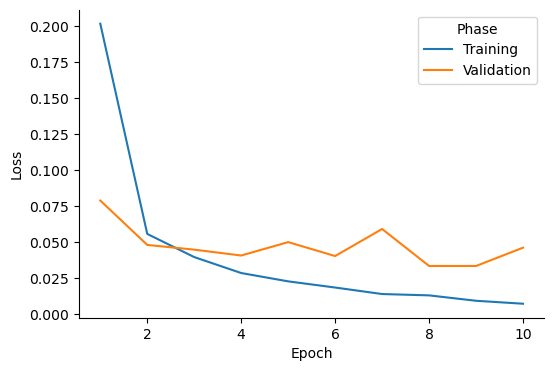

In [14]:
training_history_df = pl.DataFrame(training_history)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sns.lineplot(
    training_history_df,
    x='epoch',
    y='loss',
    hue='phase',
)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(title='Phase')
ax.spines[['right', 'top']].set_visible(False)

The following code block computes the accuracy of the trained model on the test set.

In [15]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.unsqueeze(1)  # Add channel dimension
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.argmax(axis=1)).sum().item()
print(f"Accuracy of the model on the test images: {100 * correct / total:.2f}%")

Accuracy of the model on the test images: 99.04%


The following code block defines a function that allows us to visualize specific filters in the first convolutional layer and the resulting ReLU activation function outputs.

In [16]:
def plot_conv1_filter_and_relu_activation(filter_index):

    conv1_filter_arrays = model.conv1.weight.data.numpy()
    
    conv1_filter_array = conv1_filter_arrays[filter_index]
    current_filter = conv1_filter_array[0]
    
    filter_size = len(current_filter)
    stride = 2
    padding = 0
    
    conv_output_height = np.floor((test_image.shape[0] - filter_size - 2*padding)/stride + 1).astype(np.int32)
    conv_output_width =  np.floor((test_image.shape[1] - filter_size - 2*padding)/stride + 1).astype(np.int32)
    
    # Initialize the output matrix
    conv_output = np.zeros((conv_output_height, conv_output_width))
    
    # Apply the 3x3 max pooling operation with stride 2 and valid padding
    for i in range(0, conv_output_height):
        for j in range(0, conv_output_width):
            # Calculate the starting row and column indices
            row_start = i * stride
            col_start = j * stride
            
            # Extract the 3x3 window
            window = test_image[row_start:row_start + filter_size, col_start:col_start + filter_size]
            
            # Apply max pooling (get the maximum value in the window)
            conv_output[i, j] = np.sum(window * current_filter)
    
    relu_output = np.maximum(conv_output, 0)
    
    mosaic = [
        ['Original Image', 'Filter Output', 'ReLU Output'],
    ]
    plot_mapper = {
        'Original Image': test_image,
        'Filter Output': conv_output,
        'ReLU Output': relu_output,
    }
    
    
    fig, ax = plt.subplot_mosaic(mosaic, figsize=(12, 5))
    
    for subplot_title, subplot_array in plot_mapper.items(): 
    
        ax[subplot_title].imshow(
            subplot_array,
            cmap='gray', 
        )
        ax[subplot_title].set_title(subplot_title)
    
    plt.show()

The following code block runs the previous function interactively for different filters.

In [17]:
ipywidgets.interact(
    plot_conv1_filter_and_relu_activation, 
    filter_index=ipywidgets.IntSlider(min=0, max=31)
);

interactive(children=(IntSlider(value=0, description='filter_index', max=31), Output()), _dom_classes=('widget…

# Running the Model on a GPU

If you have a compatible GPU, PyTorch can run the CNN on the device. We must send the model and data to the device when training or using the model for inference. The following code block shows how to create a variable that can be used to send the model and data to the appropriate device.

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


The following code block updates the training loop to use the GPU.

In [19]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

start_time = time.time()

training_history = []
for epoch in range(num_epochs):
    model.train()
    running_training_loss = 0.0
    for images, labels in train_loader:
        images = images.unsqueeze(1).to(device)  # Add channel dimension
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_training_loss += loss.item()

    training_loss = running_training_loss / len(train_loader)
    training_history.append({
        'epoch': epoch+1,
        'phase': 'Training',
        'loss': training_loss
    })
    
    # Validation step
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.unsqueeze(1).to(device)  # Add channel dimension
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            
    validation_loss = running_val_loss / len(val_loader)
    training_history.append({
        'epoch': epoch+1,
        'phase': 'Validation',
        'loss': validation_loss
    })

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {training_loss:.4f}, Validation Loss: {validation_loss:.4f}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f' - Training for {num_epochs} took {elapsed_time:.2f} seconds.')

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.unsqueeze(1).to(device)  # Add channel dimension
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.argmax(axis=1)).sum().item()
print(f"Accuracy of the model on the test images: {100 * correct / total:.2f}%")

Epoch [1/10], Training Loss: 0.1928, Validation Loss: 0.0742
Epoch [2/10], Training Loss: 0.0545, Validation Loss: 0.0525
Epoch [3/10], Training Loss: 0.0375, Validation Loss: 0.0418
Epoch [4/10], Training Loss: 0.0290, Validation Loss: 0.0383
Epoch [5/10], Training Loss: 0.0207, Validation Loss: 0.0441
Epoch [6/10], Training Loss: 0.0169, Validation Loss: 0.0359
Epoch [7/10], Training Loss: 0.0128, Validation Loss: 0.0358
Epoch [8/10], Training Loss: 0.0111, Validation Loss: 0.0358
Epoch [9/10], Training Loss: 0.0088, Validation Loss: 0.0413
Epoch [10/10], Training Loss: 0.0076, Validation Loss: 0.0384
 - Training for 10 took 15.82 seconds.
Accuracy of the model on the test images: 98.76%


# Working with Model Embeddings
Embeddings in neural networks refer to dense, low-dimensional vector representations of data that capture the semantic meaning or characteristics of high-dimensional input data. The main use case for embeddings is transforming complex, high-dimensional data, such as documents or images, into a form that is easier for the model to process and associate.

## Cosine Similarity
Cosine similarity is a metric used to measure the similarity between two vectors in a multi-dimensional space by calculating the cosine of the angle between them. Cosine similarity is often used in text analysis, where documents are represented as vectors of word frequencies or TF-IDF scores. By comparing the cosine similarity between document vectors, you can measure the similarity in the content of documents without being influenced by the absolute lengths of the vectors (i.e., document size or word count). It is defined as:

Cosine Similarity = $\displaystyle \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|}$

Where:
- $\displaystyle \mathbf{A} \cdot \mathbf{B}$ is the **dot product** of vectors $\mathbf{A}$ and $\mathbf{B}$.
- $\|\mathbf{A}\|$ is the **magnitude** (or length) of vector $\mathbf{A}$, calculated as $\displaystyle \|\mathbf{A}\| = \sqrt{A_1^2 + A_2^2 + \dots + A_n^2}$ for an $n$-dimensional vector $\mathbf{A} = [A_1, A_2, \dots, A_n]$.
- $\displaystyle \|\mathbf{B}\|$ is the magnitude of vector $\mathbf{B}$, calculated similarly.

### Interpreting Cosine Similarity:
- The cosine similarity ranges from $-1$ to $1$:
  - Cosine Similarity = 1 when the vectors are **identical** (i.e., point in the same direction).
  - Cosine Similarity = 0 when the vectors are **orthogonal** (i.e., there is no correlation).
  - Cosine Similarity = -1 when the vectors are **opposite** (i.e., point in opposite directions).

## Extracting Embeddings from the Trained Model

The following code block shows how we can use the trained model to extract the output of the `fc1` layer, a 128-dimensional vector, for all of the instances in the test dataset. The vector returned by `fc1` is a dense representation of the original input image that captures high-level features learned by the convolutional layers and pooling operations. Thus, it satisfies our definition of an embedding.

In [20]:
embeddings = pl.DataFrame()
image_arrays = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader, 'Extracting embeddings'):
        images = images.unsqueeze(1).to(device)  # Add channel dimension
        labels = labels.to(device)
        outputs = model(images)

        x = images
        x = model.relu(model.conv1(x))
        x = model.pool(x)
        x = model.relu(model.conv2(x))
        x = model.pool(x)
        x = x.view(-1, 64 * 5 * 5)
        embedding = model.fc1(x)
        embedding_relu = model.relu(embedding)
        output = model.fc2(embedding_relu)

        batch_embeddings = pl.DataFrame(
            embedding.detach().cpu().numpy(),
            schema=[f'd{idx}' for idx in range(1, 129)],
        ).with_columns(
            pl.Series(name='actual', values=labels.detach().cpu().numpy().argmax(axis=1).flatten()),
            pl.Series(name='predicted', values=output.detach().cpu().numpy().argmax(axis=1).flatten())
        )
        embeddings = pl.concat([embeddings, batch_embeddings])
        for image in images:
            image_arrays.append(image.detach().cpu().numpy().flatten())

embeddings = embeddings.with_columns(
    correct = pl.when(pl.col('actual') == pl.col('predicted')).then(1).otherwise(0)
)
length = len(embeddings)
embeddings = embeddings.with_columns(
    instance = pl.Series(name='instance', values=range(length))
).select(
    pl.col('instance'), 
    pl.col('actual'), 
    pl.col('predicted'),
    pl.col('correct'),
    pl.all().exclude(['instance', 'actual', 'predicted', 'correct'])
)

Extracting embeddings:   0%|          | 0/219 [00:00<?, ?it/s]

The following code block defines a function that plots a 2 x 2 subplot with a missclassified digit in the upper left and the closest 3 digits based on cosine similarity. 

In [21]:
def generate_incorrect_prediction_plot(selected_instance):

    selected_instance_data = embeddings.filter(
        pl.col('instance') == selected_instance
    )
    
    selected_instance_embedding = selected_instance_data.select(
        pl.all().exclude(['instance', 'actual', 'predicted', 'correct'])
    ).to_numpy()
    
    selected_instance_label = selected_instance_data.get_column('actual').to_numpy().flatten()[0]
    selected_instance_prediction = selected_instance_data.get_column('predicted').to_numpy().flatten()[0]
    
    cosine_similarities = cosine_similarity(
        selected_instance_embedding,
        all_embeddings_array,
    ).flatten()
    
    most_similar = cosine_similarities.argsort()[-4:-1][::-1]
    
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    
    ax[0][0].imshow(
        image_arrays[selected_instance].reshape(28, 28),
        cmap='gray',
    )
    ax[0][0].set_title(f'Actual: {selected_instance_label}\nPredicted: {selected_instance_prediction}')
    
    ax[0][1].imshow(
        image_arrays[most_similar[0]].reshape(28, 28),
        cmap='gray',
    )
    label = selected_instance_data = embeddings.filter(
        pl.col('instance') == most_similar[0]
    ).get_column('actual').to_numpy().flatten()[0]
    ax[0][1].set_title(f'Actual: {label}')
    
    ax[1][0].imshow(
        image_arrays[most_similar[1]].reshape(28, 28),
        cmap='gray',
    )
    label = selected_instance_data = embeddings.filter(
        pl.col('instance') == most_similar[1]
    ).get_column('actual').to_numpy().flatten()[0]
    ax[1][0].set_title(f'Actual: {label}')
    
    ax[1][1].imshow(
        image_arrays[most_similar[2]].reshape(28, 28),
        cmap='gray',
    )
    label = selected_instance_data = embeddings.filter(
        pl.col('instance') == most_similar[2]
    ).get_column('actual').to_numpy().flatten()[0]
    ax[1][1].set_title(f'Actual: {label}')
    
    plt.show()

The following code block runs the previously defined function for a subset of misclassified digits.

In [22]:
incorrect_instances = embeddings.filter(
    pl.col('correct') == 0
).get_column(
    'instance'
).to_list()

all_embeddings_array = embeddings.select(
    pl.all().exclude(['instance', 'actual', 'predicted', 'correct'])
).to_numpy()

ipywidgets.interact(generate_incorrect_prediction_plot, selected_instance=incorrect_instances[:10])

interactive(children=(Dropdown(description='selected_instance', options=(47, 240, 241, 256, 293, 385, 472, 488…

<function __main__.generate_incorrect_prediction_plot(selected_instance)>

# Transfer Learning (ResNet18)

Transfer learning is a machine learning technique where a model developed for a specific task is reused or adapted for another related task. Instead of training a model from scratch, transfer learning leverages knowledge gained from pre-trained models (typically trained on large datasets). It fine-tunes them for a new, often smaller dataset or different task. This approach reduces the time and computational resources required to train a model and often results in better performance, especially when the target dataset is small.

We will demonstrate transfer learning using a ResNet18 model pretrained on ImageNet. We can access these pretrained models from the `torchvision.models` module, which is imported in the following code block.

In [23]:
import torchvision.models

The following code block loads the ResNet18 model with the pretrained weights.

In [24]:
resnet_model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

A major issue that we need to address is that ResNet18 was designed to ingest images with three channels (R, G, B). Our MNIST images have a single (greyscale) channel. Another issue is that Imagenet has 1,000 different classes. We only have 10.

## Addressing Input Channel Discrepancy

The first layer in ResNet18 is a convolutional layer that expects inputs with three channels. The following code block shows how to access this model layer.

In [25]:
resnet_model.conv1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

Since we want to retain the information the network has learned, we will modify the feature data so that pixel values are duplicated across three channels. The following code block updates our `MNISTDataset` class to accept a set of transforms via a `transform` argument.

In [26]:
# Custom Dataset class
class MNISTDataset(Dataset):
    def __init__(self, features, targets, transform=None):
        self.features = features
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        
        image = self.features[idx].reshape(28, 28).astype('float32')
        label = self.targets[idx].astype('float32')

        if self.transform:
            image = self.transform(image)
            
        return torch.tensor(image), torch.tensor(label)

The following code block uses the `transforms` module from `torchvision` to define a suitable transform sequence. These will vary by model, so you need to refer to the PyTorch documentation for the pretrained model you are using.

In [27]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

The following code block recreates the Dataloader objects using the defined transform sequence. There is one important difference: We will only use 2,000 images to train. Since we are starting from a pretained model, we should be able to get a good result with less data.

In [28]:
# Load data from parquet files
feature_data_filepath = pathlib.Path('data/mnist_features.parquet')
target_data_filepath = pathlib.Path('data/mnist_target.parquet')

feature_data = pl.read_parquet(
    feature_data_filepath
)

target_data = pl.read_parquet(
    target_data_filepath
).cast(
    pl.Int32
).to_dummies()

# Convert to numpy arrays
X = feature_data.to_numpy()
y = target_data = target_data.to_numpy()

# Split the data into training (70%), validation (10%), and test (20%) sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, 
    y, 
    test_size=0.20, 
    random_state=42,
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, 
    y_train_val, 
    train_size=2_000, 
    random_state=42,
)

# Create Dataset objects
train_dataset = MNISTDataset(X_train, y_train, transform=transform)
val_dataset = MNISTDataset(X_val, y_val, transform=transform)
test_dataset = MNISTDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
)
val_loader = DataLoader(
    dataset=val_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)
test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)

## Addressing Output Number Discrepancy

The following code block shows how we can access the final output layer of the AlexNet model.

In [29]:
resnet_model.fc

Linear(in_features=512, out_features=1000, bias=True)

The following code block replaces the final layer with a new linear layer that maintains the same parameters as the original with the exception that it has 10 output features.

In [30]:
resnet_model.fc = resnet_model.fc = nn.Linear(
    in_features=resnet_model.fc.in_features,
    out_features=10,
    bias=True,
)
resnet_model.fc

Linear(in_features=512, out_features=10, bias=True)

## Fine-tuning the revised model

The following code block runs the fine-tuning without tracking validation set performance.

In [31]:
resnet_model = resnet_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)

start_time = time.time()

training_history = []
for epoch in range(10):
    resnet_model.train()
    running_training_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_training_loss += loss.item()

    training_loss = running_training_loss / len(train_loader)
    training_history.append({
        'epoch': epoch+1,
        'phase': 'Training',
        'loss': training_loss
    })

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {training_loss:.4f}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f' - Training for {num_epochs} epochs took {elapsed_time:.2f} seconds.')

resnet_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.argmax(axis=1)).sum().item()
print(f"Accuracy of the model on the test images: {100 * correct / total:.2f}%")

/tmp/ipykernel_14508/3281264605.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image), torch.tensor(label)


Epoch [1/10], Training Loss: 0.3973
Epoch [2/10], Training Loss: 0.0943
Epoch [3/10], Training Loss: 0.0504
Epoch [4/10], Training Loss: 0.0180
Epoch [5/10], Training Loss: 0.0094
Epoch [6/10], Training Loss: 0.0450
Epoch [7/10], Training Loss: 0.0304
Epoch [8/10], Training Loss: 0.0146
Epoch [9/10], Training Loss: 0.0217
Epoch [10/10], Training Loss: 0.0208
 - Training for 10 epochs took 52.70 seconds.
Accuracy of the model on the test images: 94.81%


**Acknowledgement**: This document was generated with the assistance of AI-based language modeling (via ChatGPT, OpenAI).